In [ ]:
! pip install pocketflow
! pip install faiss-cpu
! pip install openai

<p style="font-family: Arial, sans-serif; font-size: 36px; font-weight: bold; color: #333; margin: 0; padding: 0;">
Cookbook: Pocket Flow + Cursor AI
</p>

<p style="font-family: Arial, sans-serif; font-size: 24px; font-weight: bold; color: #333; margin: 4px 0; padding: 0;">
1. Utility Function
</p>

<p style="font-family: Arial, sans-serif; font-size: 16px; color: #333;">
    Utility Functions are the <b>helper functions</b> like <i>calling an LLM, generating embeddings, or using external APIs</i>.  Pocket Flow is deliberately kept minimal and does <b>NOT</b> provide any of these. 
</p>

<p style="font-family: Arial, sans-serif; font-size: 16px; color: #333;">
But don’t worry: you can simply ask Cursor AI to create them for you. 
</p>


> Help me implement (1) `call_llm` function that takes a prompt and returns the response from the OpenAI gpt-4o model. (2) `get_embedding` function that takes a text and returns the embedding from the OpenAI text-embedding-ada-002 model. 

In [4]:
from openai import OpenAI
import os

def call_llm(prompt):
    client = OpenAI(api_key=API_KEY)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

def get_embedding(text):
    client = OpenAI(api_key=API_KEY)
    response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response.data[0].embedding

# Example usage:
response = call_llm("What's the meaning of life?")
print(response)
embedding = get_embedding("What's the meaning of life?")
print(embedding)

<p style="font-family: Arial, sans-serif; font-size: 24px; font-weight: bold; color: #333; margin: 4px 0; padding: 0;">
2. Node
</p>

  <!-- Description of a Node -->
  <p style="font-family: Arial, sans-serif; font-size: 16px; color: #333;">
    A <strong>Node</strong> is your smallest unit of work with 3 steps 
    <code>prep-&gt;exec-&gt;post</code>:
  </p>

<!-- Ordered list of steps with spacing between lines inside each list item -->
<ol style="font-family: Arial, sans-serif; font-size: 16px; color: #333; margin: 20px 0; padding-left: 20px;">

<li style="margin-bottom: 16px;">
    <p style="margin: 0 0 8px 0;">
    <code>prep(shared)</code>
    </p>
    <p style="margin: 0 0 8px 0;">
    - Reads and preprocess data from the <strong>shared store</strong>.
    </p>
    <p style="margin: 0;">
    - E.g., load a file, query a database, or turn data into a string.
    </p>
</li>

<li style="margin-bottom: 16px;">
    <p style="margin: 0 0 8px 0;">
    <code>exec(prep_res)</code>
    </p>
    <p style="margin: 0 0 8px 0;">
    - Executes the core logic
    </p>
    <p style="margin: 0 0 8px 0;">
    - E.g., call an LLM, invoke remote APIs, or embed texts.
    </p>
</li>

<li style="margin-bottom: 16px;">
    <p style="margin: 0 0 8px 0;">
    <code>post(shared, prep_res, exec_res)</code>
    </p>
    <p style="margin: 0;">
    - Writes data back to the <strong>shared store</strong>.
    </p>
</li>

</ol>



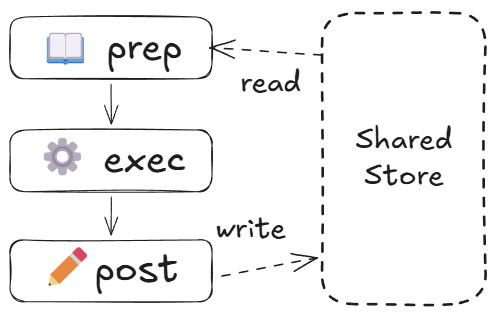

> Help me implement a single summarization node that reads data from the shared store, calls an LLM to summarize the text into 50 words, and writes the summary back to the shared store. Then, test it with a shared store that have pre-loaded data from `./data/PaulGrahamEssaysLarge/before.txt`.

In [5]:
from pocketflow import Node

class SummarizeNode(Node):
    def prep(self, shared):
        # Read data from shared store
        return shared["data"]["before.txt"]
        
    def exec(self, text):
        # Call LLM to summarize
        prompt = f"Summarize this text in 50 words:\n\n{text}"
        return call_llm(prompt)
    
    def post(self, shared, prep_res, exec_res):
        # Store the summary back
        shared["summary"] = exec_res
        # No specific next action needed
        return "default"

# Create test data
shared = {
    "data": {},
    "summary": None
}

# Load the file
with open("./data/PaulGrahamEssaysLarge/before.txt", "r") as f:
    shared["data"]["before.txt"] = f.read()

# Create and run the node
summarize_node = SummarizeNode()
summarize_node.run(shared)

# Print the result
print("Summary:", shared["summary"])

Summary: This essay highlights the counterintuitive nature of startups, emphasizing that instincts often lead to mistakes. Key advice includes trusting instincts about people, not needing deep startup knowledge, and focusing on creating products users want. Startups are all-consuming, best pursued after college, and require openness to learning and serendipity.


  <!-- Title -->
  <p style="font-family: Arial, sans-serif; font-size: 24px; font-weight: bold; color: #333; ">
    3. Batch
  </p>

  <!-- Description of Batch processing -->
  <p style="font-family: Arial, sans-serif; font-size: 16px; color: #333; margin-bottom: 16px;">
    <strong>Batch</strong> helps repeat the same work multiple items. 
    Instead of calling <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">exec()</code> once, a Batch Node calls 
    <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">exec()</code> 
    for each item in a list from <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">prep()</code>. 
  </p>
  <p style="font-family: Arial, sans-serif; font-size: 16px; color: #333; margin-bottom: 16px;">
    Think of it as "item-by-item" processing:
  </p>

  <!-- Bullet points -->
  <ul style="font-family: Arial, sans-serif; font-size: 16px; color: #333; list-style-type: disc; padding-left: 20px;">
    <li style="margin-bottom: 16px;">
      <code>prep(shared)</code>: Return a list of items.
    </li>
    <li style="margin-bottom: 16px;">
      <code>exec(item)</code>: Called once per item.
    </li>
    <li style="margin-bottom: 16px;">
      <code>post(shared, item_list, results_list)</code>: Combines all results.
    </li>
  </ul>


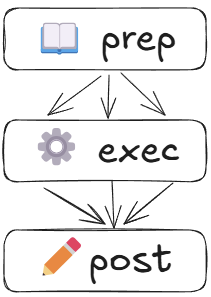

> Help me implement a batch summarization node that reads the list of data from the shared store, calls an LLM to summarize the text into 50 words, and writes the summary back to the shared store. Then, test it with a shared store that have pre-loaded all text files from `./data/PaulGrahamEssaysLarge/`.

In [6]:
from pocketflow import BatchNode
import os

class BatchSummarizeNode(BatchNode):
    def prep(self, shared):
        # Return list of (filename, content) tuples from shared store
        return [(fn, content) for fn, content in shared["data"].items()]
        
    def exec(self, item):
        # Unpack the filename and content
        filename, text = item
        # Call LLM to summarize
        prompt = f"Summarize this text in 50 words:\n\n{text}"
        summary = call_llm(prompt)
        return filename, summary
    
    def post(self, shared, prep_res, exec_res_list):
        # Store all summaries in a dict by filename
        shared["summaries"] = {
            filename: summary 
            for filename, summary in exec_res_list
        }
        return "default"

# Create test data structure
shared = {
    "data": {},
    "summaries": {}
}

# Load all files from the directory
path = "./data/PaulGrahamEssaysLarge"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r") as f:
        shared["data"][filename] = f.read()

# Create and run the batch node
batch_summarize = BatchSummarizeNode()
batch_summarize.run(shared)

# Print results
print("Summaries:")
for filename, summary in shared["summaries"].items():
    print(f"\n{filename}:")
    print(summary)

Summaries:

aord.txt:
The text discusses the critical concern of whether startups are "default alive" or "default dead," meaning whether they can reach profitability with existing resources. Many founders are unaware of this status. Addressing this concern early is vital since assumptions about easy fundraising can be misleading. Over-hiring is a common pitfall, emphasizing growth over prudent scaling.

apple.txt:
Apple's App Store approval process is harming its reputation with developers, damaging their goodwill and causing app delays. The approval system, akin to outdated software publishing, obstructs modern iterative app development. This misalignment with programmers' needs risks alienating talented potential employees and developers essential for Apple's platform success.

avg.txt:
In 1995, Paul Graham and Robert Morris founded Viaweb, a startup enabling users to create online stores. Using Lisp for its innovative capabilities, they gained a competitive edge due to Lisp's rapid 

  <!-- Title -->
  <p style="font-family: Arial, sans-serif; font-size: 24px; font-weight: bold; color: #333; ">
    4. Flow
  </p>

  <!-- Brief description of Flow -->
  <p style="font-family: Arial, sans-serif; font-size: 16px; color: #333; margin: 4px 0;">
    <strong>Flow</strong> connects your Nodes to a graph.
  </p>

  <!-- Unordered list of key points -->
  <ul style="font-family: Arial, sans-serif; font-size: 16px; color: #333; list-style-type: disc; margin: 10px 0; padding-left: 20px;">
    <li style="margin-bottom: 8px;">
      <strong>Chaining</strong> 
      (<code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">node_1 &gt;&gt; node_2</code>): Break down complex problems into simple chained steps.
    </li>
    <li style="margin-bottom: 8px;">
      <strong>Directed Branching</strong> 
      (<code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">node_1 - "action" -&gt;&gt; node_2</code>): 
      Agentic decisions—where a Node’s 
      <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">post()</code> return the action string.
    </li>
    <li style="margin-bottom: 8px;">
      <strong>Set a Start Point</strong>: Create flow by specifying 
      <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">Flow(start=node_a)</code>. 
      Then call 
      <code style="background: #f2f2f2; padding: 2px 4px; border-radius: 3px;">flow.run(shared)</code>.
    </li>
  </ul>

  <!-- Closing note -->
  <p style="font-family: Arial, sans-serif; font-size: 16px; color: #333; margin: 0; padding: 0;">
    That’s it! You can nest Flows, branch your actions, or keep it simple with a straight chain of Nodes.
  </p>

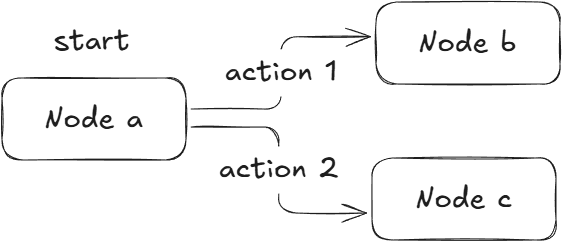

> Help me implement a RAG chatbot that, given a user’s input question, finds the most relevant file based on embeddings and then answers the user's question. Test it with a shared store that has preloaded all text files from `./data/PaulGrahamEssaysLarge/`.

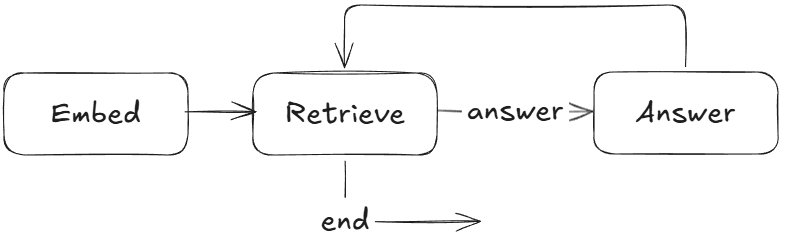

In [12]:
from pocketflow import Node, Flow
import faiss
import numpy as np
import os

class PrepareEmbeddings(Node):
    def prep(self, shared):
        # Get list of (filename, content) pairs
        return list(shared["data"].items())
        
    def exec(self, items):
        # Create embeddings for each document
        embeddings = []
        filenames = []
        for filename, content in items:
            embedding = get_embedding(content)
            embeddings.append(embedding)
            filenames.append(filename)
            
        # Create FAISS index
        dim = len(embeddings[0])
        index = faiss.IndexFlatL2(dim)
        index.add(np.array(embeddings).astype('float32'))
        
        return index, filenames
    
    def post(self, shared, prep_res, exec_res):
        # Store index and filenames in shared store
        index, filenames = exec_res
        shared["search_index"] = index
        shared["filenames"] = filenames
        return "default"

class FindRelevantDocument(Node):
    def prep(self, shared):
        # Get user question
        question = input("Enter your question (or press Enter to quit): ")
        if not question:
            return None
        return question
        
    def exec(self, question):
        if question is None:
            return None
            
        # Get question embedding and search
        query_embedding = get_embedding(question)
        
        # Search for most similar document
        D, I = shared["search_index"].search(
            np.array([query_embedding]).astype('float32'),
            k=1
        )
        most_relevant_idx = I[0][0]
        most_relevant_file = shared["filenames"][most_relevant_idx]
        
        return question, most_relevant_file
        
    def post(self, shared, prep_res, exec_res):
        if exec_res is None:
            return "end"
            
        question, filename = exec_res
        shared["current_question"] = question
        shared["relevant_file"] = filename
        shared["context"] = shared["data"][filename]
        return "answer"
    
class AnswerQuestion(Node):
    def prep(self, shared):
        return (
            shared["current_question"],
            shared["context"]
        )
        
    def exec(self, inputs):
        question, context = inputs
        prompt = f"""
Context: {context}

Question: {question}

Answer the question based on the context above. If the context doesn't contain relevant information, say so.
Answer:"""
        return call_llm(prompt)
    
    def post(self, shared, prep_res, exec_res):
        print(f"\nQ: {shared['current_question']}")
        print(f"A: {exec_res}")
        print(f"\nSource: {shared['relevant_file']}")
        return "continue"  # Loop back for more questions

# Create test data
shared = {"data": {}}

# Load all files
path = "./data/PaulGrahamEssaysLarge"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), "r") as f:
        shared["data"][filename] = f.read()

# Create nodes and flow
prep_embeddings = PrepareEmbeddings()
find_relevant = FindRelevantDocument()
answer = AnswerQuestion()

# Connect nodes
prep_embeddings >> find_relevant
find_relevant - "answer" >> answer
find_relevant - "end" >> None
answer - "continue" >> find_relevant

# Create and run flow
rag_flow = Flow(start=prep_embeddings)
rag_flow.run(shared)


Q: how to find startup idea
A: To find a startup idea, the context advises not to make a conscious effort to think of startup ideas, as this often results in bad and plausible-sounding ideas that can waste time. Instead, it suggests turning your mind into the type that generates startup ideas unconsciously. This can be achieved by:

1. Learning extensively about things that matter.
2. Working on problems that genuinely interest you.
3. Collaborating with people you like and respect.

By engaging in these activities, you'll naturally start to encounter ideas that have the potential to become startups, often without initially realizing it. The essay emphasizes that many successful startups, like Apple, Yahoo, Google, and Facebook, began as side projects rather than direct pursuits to start a company.

Source: before.txt


/home/zh2408/.venv/lib/python3.9/site-packages/pocketflow/__init__.py:43: UserWarning: Flow ends: 'end' not found in ['answer', 'end']
  if not nxt and curr.successors: warnings.warn(f"Flow ends: '{action}' not found in {list(curr.successors)}")
